# Trabalho Prático de K-Means

**Disciplina**: Algoritmos e Estruturas de Dados II (2020/02)

**Giovanna Souza Teodoro** - 1915080065

**Victor Hugo Santos de Lima** - 1915080025

*Antes de executar as células, favor montar o drive com o código abaixo.*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*É possível também fazer upload dos arquivos necessários pela célula abaixo.*

In [ ]:
from google.colab import files
uploaded = files.upload()

# Setup

In [ ]:
'''
  Conjunto de bibliotecas necessárias ao longo da execução das células
'''
import matplotlib.pyplot as plt       # Plotagem 
%matplotlib inline
import pandas as pd                   # Leitura do csv 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from nltk.stem.porter import PorterStemmer

'''
  Descomente a linha a partir do método pelo qual optou 
'''
# PELO DRIVE
dataframeRouters = pd.read_csv('/content/drive/Shareddrives/AED3TeodoroHugo/routers.txt', names=["category", "instances"])


# PELO UPLOAD
#dataframeRouters = pd.read_csv('./routers.txt', names=["category", "instances"])

# Construção

In [ ]:
# Criação de um array com todas as sentenças

palavras = []

for i in dataframeRouters["instances"]:
    palavras.append(i)

# Tratamento das sentenças utilizando o método de "Stemming"

p_stemmer = PorterStemmer()

palavras3 = []

for word in palavras:
    if(len(word.split()) > 1):
        aux = ''
        for subword in word.split():
            aux += p_stemmer.stem(subword) + ' '
        palavras3.append(aux[:-1])
    elif word == "software/app":
        palavras3.append("softwar/app")
    elif word == "extention":
        palavras3.append("extend")
    else:        
        palavras3.append(p_stemmer.stem(word))

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')

# Transformação das sentenças em valores numéricos utilizando o método "TF-IDF"
X = vectorizer.fit_transform(palavras3)

In [ ]:
# Similaridade por cosseno
dist = (1 - cosine_similarity(X))

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)

# Redução da dimensionalidade dos valores numéricos para duas dimensões
pos = mds.fit_transform(dist)

In [ ]:
pca = PCA(n_components=2, random_state=42)

pca_result = pca.fit_transform(pos)

# Criação da coluna x e y no dataframe 
dataframeRouters['x'] = pca_result[:, 0]
dataframeRouters['y'] = pca_result[:, 1]

# K-means

In [ ]:
kmeans = KMeans(n_clusters=9, max_iter=400, random_state=24).fit(pca_result)

# Criação da coluna "cluster" no dataframe
dataframeRouters['cluster'] = kmeans.predict(pca_result)

# Obtenção de uma matriz com as posições dos centroides 
centroids = kmeans.cluster_centers_

In [ ]:
# Definição das cores de cada cluster
colors = ['#5E005E', '#AB11AB', '#5E4C09', '#095E52', '#09AB92', '#B5FF5E', '#7897FF', '#76B330', '#CDD1AE']
dataframeRouters['color'] = dataframeRouters.cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3], 4:colors[4], 5:colors[5], 6:colors[6], 7:colors[7], 8:colors[8]})

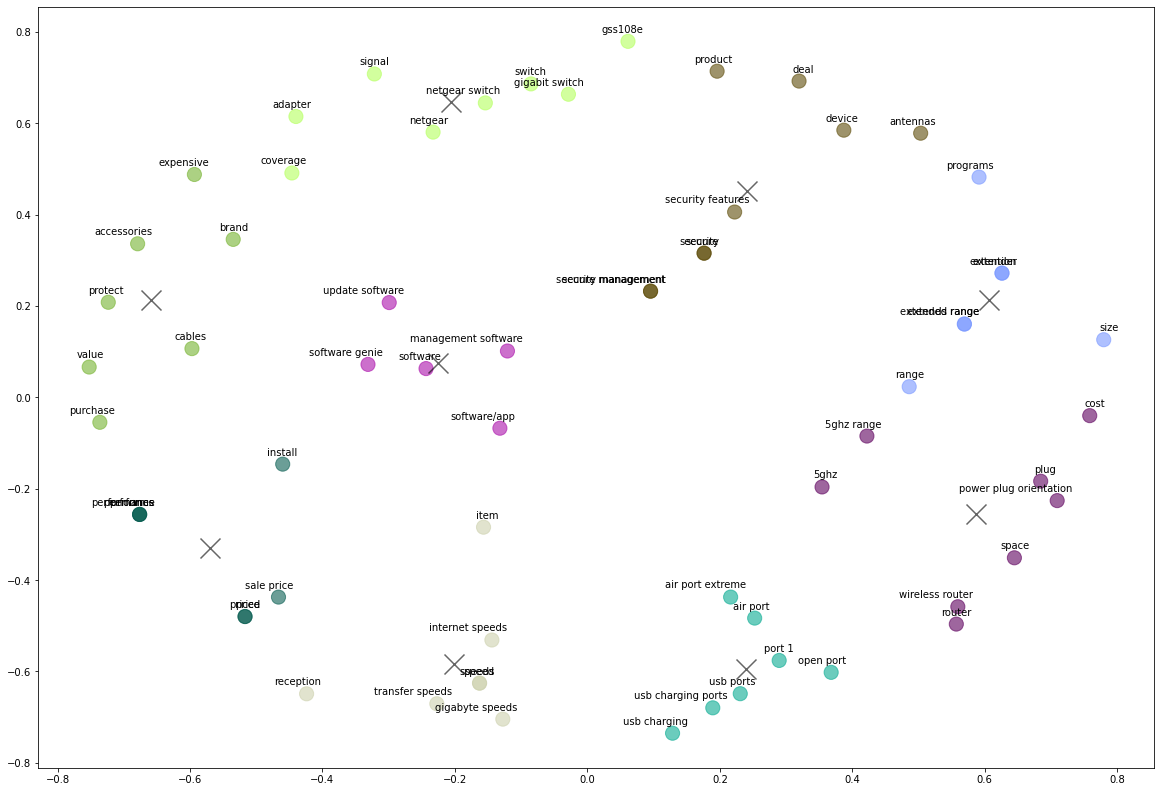

In [ ]:
plt.subplots(figsize=(20, 14))

# Plotagem dos pontos e centroides
plt.scatter(dataframeRouters.x, dataframeRouters.y, c=dataframeRouters.color, alpha = 0.6, s=200)
plt.scatter(centroids[:,0], centroids[:,1], c='black', alpha = 0.6, s=400, marker='x')

labels = dataframeRouters['instances'].to_list()
x = dataframeRouters['x'].to_list()
y = dataframeRouters['y'].to_list()

# Plotagem das labels 
for i in range(len(x)):
    plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(15, 7),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
plt.show()

# Métricas

A variável *categorias* corresponde aos grupos na ordem que eles foram clusterizados. Ou seja, se o grupo "dimension" está no index 0, significa que o cluster que o representa é o cluster 0. Os pontos que mais estão relacionados à "software" estão no cluster 1 (por isso ele ganhou o index 1), assim por diante. 

**PRECISÃO:** número de acertos da resposta / número total das respostas

**REVOCAÇÃO:** número de acertos do gabarito / número total do gabarito 

**F1:** (2xPxR)/P+R <- quanto maior, melhor 

In [ ]:
categorias = ["dimension","software","security","price","port","general","coveragearea","accessory","speed"]

def acertos(df, categorias=categorias):
  acertos = [0]*len(categorias)
  for i in range(len(df)):
    for j in range(len(categorias)):
      if (df['category'][i] == categorias[j] and df['cluster'][i] == categorias.index((df['category'][i]))):
        acertos[j] += 1 
  return acertos

def revocacao(df, categorias = categorias, acertos = acertos(dataframeRouters)):
  frequencia = df['category'].value_counts()
  frequencia = frequencia.to_dict()
  fq_respostas = [0]*len(categorias)
  for x in range (len(categorias)):
    fq_respostas[x] = frequencia[str (categorias[x])]
  for w in range(len(categorias)):
    fq_respostas[w] = acertos[w]/fq_respostas[w]
  return fq_respostas

def precisao(df, categorias = categorias, acertos = acertos(dataframeRouters)):
  frequencia1 = df['cluster'].value_counts()
  fq_gabarito = [0]*len(categorias)
  for x in range (len(categorias)):
    fq_gabarito[x] = frequencia1[x]
  for w in range(len(categorias)):
    fq_gabarito[w] = acertos[w]/fq_gabarito[w]
  return fq_gabarito 

def f1(p,r):
  f1 = []
  for x in range (len(p)):
    f1.append(((2*(p[x]*r[x]))/(p[x]+r[x]))*100)
  return f1

In [ ]:
r = revocacao(dataframeRouters)
p = precisao(dataframeRouters)
f = f1(p,r)

# Conclusão

In [ ]:
df = dataframeRouters.drop('color',axis=1)
df = df.drop('x',axis=1)
df = df.drop('y',axis=1)

In [ ]:
for i in range(len(categorias)):
  print("----------------------------------------------------")
  print("CORRESPONDENTES AO CLUSTER", i)
  print((df[df.cluster == i]).to_string(index=False))
  print()
  print("CORRESPONDENTES À CATEGORIA", str (categorias[i]).upper())
  print((df[df.category == categorias[i]]).to_string(index=False))
  print("F1: ", f[i])
  print()


----------------------------------------------------
CORRESPONDENTES AO CLUSTER 0
     category               instances  cluster
      general         wireless router        0
      general                  router        0
    dimension                   space        0
        price                    cost        0
    accessory  power plug orientation        0
    accessory                    plug        0
        speed                    5ghz        0
 coveragearea              5ghz range        0

CORRESPONDENTES À CATEGORIA DIMENSION
  category instances  cluster
 dimension     space        0
 dimension      size        6
F1:  20.0

----------------------------------------------------
CORRESPONDENTES AO CLUSTER 1
 category            instances  cluster
 software             software        1
 software         software/app        1
 software       software genie        1
 software  management software        1
 software      update software        1

CORRESPONDENTES À CATEGORIA SOFT

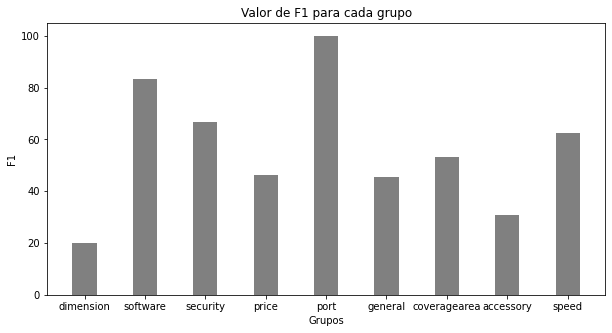

In [ ]:
fig = plt.figure(figsize = (10, 5))
plt.bar(categorias, f, color ='gray', width = 0.4)
plt.xlabel("Grupos")
plt.ylabel("F1")
plt.title("Valor de F1 para cada grupo")
plt.show()

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(dataframeRouters)

        category               instances         x         y  cluster    color
0       security       security features  0.222343  0.405440        2  #5E4C09
1       security     security management  0.095398  0.232281        2  #5E4C09
2       security                security  0.176210  0.315432        2  #5E4C09
3       security                  secure  0.176210  0.315432        2  #5E4C09
4       security                 protect -0.723388  0.207953        7  #76B330
5       security       secure management  0.095398  0.232281        2  #5E4C09
6        general                  device  0.387221  0.584562        2  #5E4C09
7        general          gigabit switch -0.028592  0.663186        5  #B5FF5E
8        general                  switch -0.085177  0.685777        5  #B5FF5E
9        general                    deal  0.319593  0.691974        2  #5E4C09
10       general         wireless router  0.559336 -0.458300        0  #5E005E
11       general                 product  0.195879  

# Referências bibliográficas


* STARMER, Josh. **K-means clustering.** Disponível em: https://www.youtube.com/watch?v=4b5d3muPQmA&t=192s. Acesso em 05 de jul. de 2021. 

* Towards Data Science. **Using Word Vectors to Mathematically Find Words with Similar Meanings.** Disponível em: https://towardsdatascience.com/using-word-vectors-to-mathematically-find-words-with-similar-meanings-fc9eadac3dbe. Acesso em 05 de jul de 2021. 

* Python Tutorials for Digital Humanities. **Plotting TF-IDF and K-Means Data with Matplotlib**. Disponível em: https://www.youtube.com/watch?v=B0BkUNMqfSo. Acesso em 06 de jul. de 2021. 

* Analytics Vidhya. **A Simple Guide to Metrics for Calculating String Similarity**. Disponível em: https://www.analyticsvidhya.com/blog/2021/02/a-simple-guide-to-metrics-for-calculating-string-similarity/. Acesso em 06 de jul. de 2021. 

* RADECIC, Dario. **Calculating String Similarity in Python**. Disponível em: https://towardsdatascience.com/calculating-string-similarity-in-python-276e18a7d33a. Acesso em 07 de jul. de 2021. 

* Towards Data Science. **Understanding NLP Word Embeddings — Text Vectorization**. Disponível em: https://towardsdatascience.com/understanding-nlp-word-embeddings-text-vectorization-1a23744f7223. Acesso em 08 de jul. de 2021. 

* PANTOLA, Paritosh. **Natural Language Processing: Text Data Vectorization.** Disponível em: https://medium.com/@paritosh_30025/natural-language-processing-text-data-vectorization-af2520529cf7. Acesso em 08 de jul. de 2021. 

* Scikit-Learn Organization. **Machine Learning in Python.** Disponível em: https://scikit-learn.org/. Acesso em 05 de jul. de 2021. 



